In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
import string
import nltk
from nltk.corpus import stopwords
import re
import random

In [4]:
from sklearn import model_selection, preprocessing, feature_extraction, linear_model, metrics, pipeline, svm, neighbors

In [5]:
from functools import partial

In [6]:
data = pd.read_csv('dataset/IMDB_dataset.csv')

In [7]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
data.sentiment.replace("positive", 1, inplace = True)
data.sentiment.replace("negative", 0, inplace = True)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [9]:
X = data['review']
y = data['sentiment']

In [10]:
# radimo izbor hiperparametara pomocu validacionog skupa
X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=1234)

In [11]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=1234)

In [12]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((26800,), (6700,), (16500,), (26800,), (6700,), (16500,))

In [13]:
y_train.value_counts()

1    13400
0    13400
Name: sentiment, dtype: int64

In [14]:
y_val.value_counts()

0    3350
1    3350
Name: sentiment, dtype: int64

In [15]:
y_test.value_counts()

0    8250
1    8250
Name: sentiment, dtype: int64

## Bag of Words i TF-IDF vektorizacija

In [16]:
# pomocne funkcije iz 01:
def simple_tokenization(review):
    tokens = nltk.tokenize.word_tokenize(review)
    tokens_without_punctuation = [token for token in tokens if token not in string.punctuation]
    return tokens_without_punctuation

In [17]:
def short_form_transform(text):
    text=re.sub("isn't", 'is not', text)
    text=re.sub("aren't", 'are not', text)
    text=re.sub("he's", 'he is', text)
    text=re.sub("wasn't", 'was not',text)
    text=re.sub("there's", 'there is',text)
    text=re.sub("couldn't",'could not',text)
    text=re.sub("can't", 'can not', text)
    text=re.sub("won't", 'will not',text)
    text=re.sub("they're", 'they are',text)
    text=re.sub("she's", 'she is',text)
    text=re.sub("wouldn't", 'would not',text)
    text=re.sub("haven't", 'have not',text)
    text=re.sub("that's", 'that is',text)
    text=re.sub("you've", 'you have',text)
    text=re.sub("he's", 'he is',text)
    text=re.sub("what's", 'what is',text)
    text=re.sub("weren't", 'were not',text)
    text=re.sub("we're", 'we are',text)
    text=re.sub("hasn't", 'has not',text)
    text=re.sub('i’d','i would',text)
    text=re.sub("you'd",'you would',text)
    text=re.sub("shouldn't",'should not',text)
    text=re.sub("let's",'let us',text)
    text=re.sub("i've", 'i have', text)
    text=re.sub("you've", 'you have', text)
    text=re.sub("we've", 'we have', text)
    text=re.sub("they've",'they have',text)
    text=re.sub("you'll",'you will',text)
    text=re.sub("i'm",'i am',text)
    text=re.sub("we've",'we have',text)
    text=re.sub("it's",'it is',text)
    text=re.sub("don't",'do not',text)
    text=re.sub("doesn't", 'does not',text)
    text=re.sub("didn't", 'did not', text)
    text=re.sub("hadn't", 'had not', text)
    text=re.sub("mightn't", 'might not', text)
    text=re.sub("mustn't", 'must not', text)
    text=re.sub("it's",'it is',text)
    return text

In [18]:
# eliminacija html tagova
def strip_html(review):
    return re.sub('<[^<]+?>', '', review)

# eliminacija url-ova
def strip_url(review):
    return re.sub(r'http\S+', '', review)

# c.g.i -> cgi, u.s.a -> usa
def full_stop_abbrev_elim(review):
    pattern = re.compile(r'\b(?:[a-z]\.){2,}', re.I)
    review = pattern.sub(lambda m: m.group().replace('.',''), review)
    return review

def remove_stop_words(tokens):
    stopwords_list = stopwords.words('english')
    tokens_without_stop = [token.strip() for token in tokens if token.strip() not in stopwords_list]
    return tokens_without_stop

In [19]:
def review_preprocessor(text):
    text = text.lower()
    text = short_form_transform(text)
    text = strip_html(text)
    text = strip_url(text)
    text = full_stop_abbrev_elim(text)
    return text

In [20]:
# najmanje agresivan:
# stemmer = nltk.stem.PorterStemmer(mode='NLTK_EXTENSIONS') # default mode (NLTK_EXTENSIONS) se pokazao kao najbolji
# nesto agresivniji:
# stemmer = nltk.stem.snowball.SnowballStemmer(language='english')
# najagresivniji:
# stemmer = nltk.stem.lancaster.LancasterStemmer()

def review_tokenizer(stemming, text):
    tokens = simple_tokenization(text)
    tokens = remove_stop_words(tokens)
            
    stems = []
        
    for token in tokens:
        
        token_pattern = re.compile(r'\b[^\W\d_]+\b')
        if not token_pattern.match(token) or len(token) <= 2:
            continue
        
        stem = stemming.stem(token)
        stems.append(stem)
    return stems

In [21]:
def init_vectorizer(vect_type: str, preprocessor, tokenizer, min_df, max_df, norm='l2', smooth_idf=True, use_idf=True):
    if type(vect_type) is not str:
        raise TypeError("vect_type must be string!")
    if vect_type.lower() not in ['count', 'tf-idf']:
        raise ValueError("Supported vectorization types: 'count', 'td-idf'!")
    
    if vect_type.lower() == 'count':
        return feature_extraction.text.CountVectorizer(preprocessor=preprocessor, tokenizer=tokenizer, min_df=min_df,
                                                         max_df=max_df, token_pattern=None)
    
    if vect_type.lower() == 'tf-idf':
        return feature_extraction.text.TfidfVectorizer(preprocessor=preprocessor, tokenizer=tokenizer, min_df=min_df,
                                                        max_df=max_df, token_pattern=None,
                                                        norm=norm, smooth_idf=smooth_idf, use_idf=use_idf)

In [22]:
review_tokenizer_snowball = partial(review_tokenizer, nltk.stem.snowball.SnowballStemmer(language='english') )
vectorizer1 = init_vectorizer(vect_type='tf-idf', preprocessor=review_preprocessor, tokenizer=review_tokenizer_snowball,
                                min_df=0.05, max_df=0.7)
# min_df - hocemo da izbacimo jako retke reci
# max_df - hocemo da izbacimo preceste reci (corpus-specific stopwords)

In [23]:
vectorizer1.fit(X_train)

TfidfVectorizer(max_df=0.7, min_df=0.05,
                preprocessor=<function review_preprocessor at 0x0000023D3D440670>,
                token_pattern=None,
                tokenizer=functools.partial(<function review_tokenizer at 0x0000023D3D440AF0>, <nltk.stem.snowball.SnowballStemmer object at 0x0000023D3D3FBEE0>))

In [24]:
# sve reci u vokabularu
vectorizer1.get_feature_names_out()

array(['absolut', 'act', 'action', 'actor', 'actual', 'almost', 'along',
       'also', 'although', 'alway', 'amaz', 'american', 'anoth', 'anyon',
       'anyth', 'appear', 'around', 'ask', 'attempt', 'audienc', 'aw',
       'away', 'back', 'bad', 'base', 'beauti', 'becom', 'begin',
       'believ', 'best', 'better', 'big', 'bit', 'black', 'book', 'bore',
       'boy', 'bring', 'budget', 'call', 'came', 'camera', 'care', 'case',
       'cast', 'certain', 'chang', 'charact', 'classic', 'clear', 'close',
       'come', 'comedi', 'comment', 'complet', 'consid', 'could', 'coupl',
       'cours', 'creat', 'dark', 'day', 'dead', 'death', 'decid',
       'definit', 'dialogu', 'die', 'differ', 'direct', 'director',
       'disappoint', 'done', 'dvd', 'earli', 'effect', 'either', 'els',
       'emot', 'end', 'enjoy', 'enough', 'entertain', 'entir', 'episod',
       'especi', 'even', 'ever', 'everi', 'everyon', 'everyth', 'exampl',
       'excel', 'except', 'expect', 'experi', 'extrem', 'eye', '

In [25]:
X_train_vectorized = vectorizer1.transform(X_train)
X_val_vectorized = vectorizer1.transform(X_val)

In [26]:
X_train_vectorized.shape, X_val_vectorized.shape

((26800, 351), (6700, 351))

### Logisticka regresija

In [27]:
Cs = np.array([10**i for i in range(-5,5)])
penalties = np.array(['l1', 'l2', 'elasticnet'])
l1_ratios = np.array([0.1 * i for i in range(1, 10)])

best_score = float('-inf')
best_C = None
best_penalty = None
best_l1_ratio = None

for C in Cs:
    for penalty in penalties:
        
        if penalty == 'l2': 
            model = linear_model.LogisticRegression(C=C, max_iter=500, penalty=penalty, solver='lbfgs')
            model.fit(X_train_vectorized, y_train)
        
            score = metrics.accuracy_score(y_val, model.predict(X_val_vectorized))
            # print(f'C: {C} penalty: {penalty} - score: {score}')
            if score > best_score:
                best_score = score
                best_C = C
                best_penalty = penalty
        
        if penalty == 'l1': 
                                                                                     # 'lbfgs' ne podrzava
            model = linear_model.LogisticRegression(C=C, max_iter=500, penalty=penalty, solver='liblinear')
            model.fit(X_train_vectorized, y_train)
        
            score = metrics.accuracy_score(y_val, model.predict(X_val_vectorized))
            # print(f'C: {C} penalty: {penalty} - score: {score}')
            if score > best_score:
                best_score = score
                best_C = C
                best_penalty = penalty   
        
        
        if penalty == 'elasticnet':
            
            for l1_ratio in l1_ratios:
                                                                                     # 'lbfgs' ne podrzava
                model = linear_model.LogisticRegression(C=C, max_iter=500, penalty=penalty, solver='saga', l1_ratio=l1_ratio)
                model.fit(X_train_vectorized, y_train)
        
                score = metrics.accuracy_score(y_val, model.predict(X_val_vectorized))
                # print(f'C: {C} penalty: {penalty} l1_ratio: {l1_ratio} - score: {score}')
                if score > best_score:
                    best_score = score
                    best_C = C
                    best_penalty = penalty 
                    best_l1_ratio = l1_ratio
                    
# print("----------------------------------------------------------------------------------------------")
if best_penalty == 'elasticnet':
    print(f'Najbolja vrednost regularizacionog hiperparametra: {best_C}\nNajbolja norma regularizacije: {best_penalty}')
    print(f'Najbolji l1_ratio: {best_l1_ratio}\nNajbolji skor: {best_score}')
else:
    print(f'Najbolja vrednost regularizacionog hiperparametra: {best_C}\nNajbolja norma regularizacije: {best_penalty}')
    print(f'Najbolji skor: {best_score}')

Najbolja vrednost regularizacionog hiperparametra: 1.0
Najbolja norma regularizacije: elasticnet
Najbolji l1_ratio: 0.4
Najbolji skor: 0.8365671641791045


In [28]:
vectorizer2 = init_vectorizer(vect_type='tf-idf', preprocessor=review_preprocessor, tokenizer=review_tokenizer_snowball,
                                min_df=0.05, max_df=0.7)

In [29]:
vectorizer2.fit(X_train_val)

TfidfVectorizer(max_df=0.7, min_df=0.05,
                preprocessor=<function review_preprocessor at 0x0000023D3D440670>,
                token_pattern=None,
                tokenizer=functools.partial(<function review_tokenizer at 0x0000023D3D440AF0>, <nltk.stem.snowball.SnowballStemmer object at 0x0000023D3D3FBEE0>))

In [30]:
X_train_val_vec = vectorizer2.transform(X_train_val)
X_test_vec = vectorizer2.transform(X_test)

In [31]:
X_train_val_vec.shape, X_test_vec.shape

((33500, 353), (16500, 353))

In [32]:
final_lr_model = None
if best_penalty == 'l2':
    final_lr_model = linear_model.LogisticRegression(C=best_C, max_iter=500, penalty=best_penalty, solver='lbfgs')
if best_penalty == 'l1':
    final_lr_model = linear_model.LogisticRegression(C=best_C, max_iter=500, penalty=best_penalty, solver='liblinear')
if best_penalty == 'elasticnet':
    final_lr_model = linear_model.LogisticRegression(C=best_C, max_iter=500, penalty=best_penalty,
                                                     solver='saga', l1_ratio=best_l1_ratio)

In [33]:
final_lr_model.fit(X_train_val_vec, y_train_val)

LogisticRegression(l1_ratio=0.4, max_iter=500, penalty='elasticnet',
                   solver='saga')

In [34]:
lr_train_score = final_lr_model.score(X_train_val_vec, y_train_val)
print(lr_train_score)

0.8402089552238806


In [35]:
lr_test_score = final_lr_model.score(X_test_vec, y_test)
print(lr_test_score)

0.8350909090909091


In [36]:
y_test_predicted = final_lr_model.predict(X_test_vec)

In [37]:
print(metrics.classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      8250
           1       0.83      0.85      0.84      8250

    accuracy                           0.84     16500
   macro avg       0.84      0.84      0.84     16500
weighted avg       0.84      0.84      0.84     16500



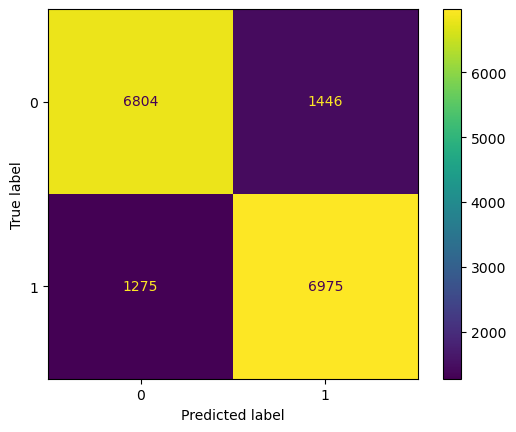

In [38]:
confusion_matrix = metrics.confusion_matrix(y_test, y_test_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

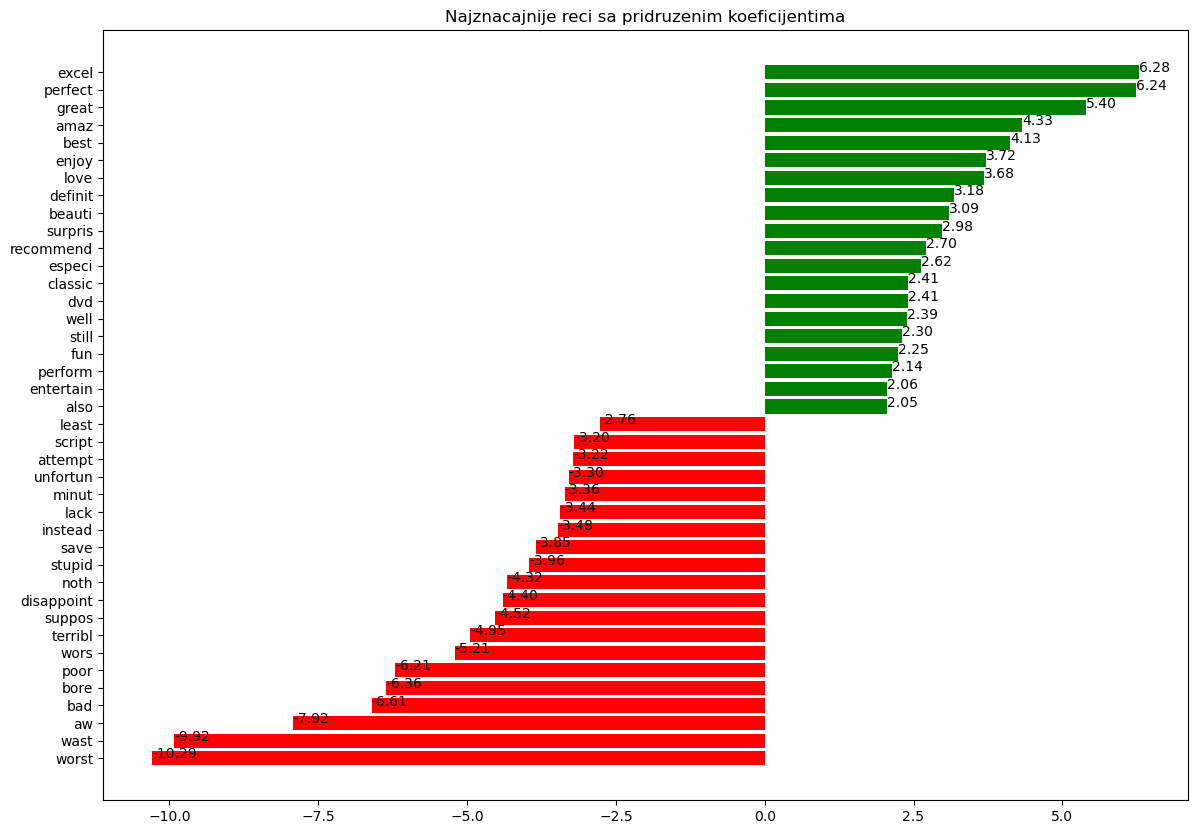

In [103]:
coefs = final_lr_model.coef_.reshape(-1)

pos_coeff_indices = np.argsort(coefs)[-20:]
neg_coeff_indices = np.argsort(coefs)[:20]
    
indices = np.hstack((neg_coeff_indices, pos_coeff_indices))
    
plt.figure(figsize=(14,10))
plt.title('Najznacajnije reci sa pridruzenim koeficijentima')
colors = ['red' if c < 0 else 'green' for c in coefs[indices]]
plt.barh(y=np.arange(40), width=coefs[indices], color=colors)

plt.yticks(ticks=np.arange(40), labels=np.array(vectorizer2.get_feature_names_out())[indices])


for index, value in enumerate(coefs[indices]):
    plt.text(value, index, "{:.2f}".format(value))
plt.show()

### Kernelizovani SVM

In [60]:
X_train_vectorized.shape, X_val_vectorized.shape

((26800, 351), (6700, 351))

In [61]:
Cs = np.array([10**i for i in range(-3, 3)])
# scale - 1 / (n_features * X.var())
# auto - 1/ n_features
gammas = ['scale', 'auto']
kernels = ['linear', 'rbf', 'sigmoid']

best_score = float('-inf')
best_params = {'C': None, 'gamma': None, 'kernel': None}

for C in Cs:
    for gamma in gammas:
        for kernel in kernels:
            model = svm.SVC(C=C, gamma=gamma, kernel=kernel)
            
            model.fit(X_train_vectorized, y_train)
            score = metrics.accuracy_score(y_val, model.predict(X_val_vectorized))                        
            # print(f'C: {C} gamma: {gamma} kernel: {kernel} - score: {score}')
            if score > best_score:
                best_score = score
                best_params['C'] = C
                best_params['gamma'] = gamma
                best_params['kernel'] = kernel


# print('------------------------------------------------------------------------')
print(f"Najbolja vrednost regularizacionog hiperparametra: {best_params['C']}")
print(f"Najbolji tip kernela: {best_params['kernel']}")

if best_params['kernel'] != 'linear':
    print(f"Najbolji koeficijent kernela: {best_params['gamma']}")

print(f'Najbolji skor: {best_score}')

Najbolja vrednost regularizacionog hiperparametra: 1.0
Najbolji tip kernela: rbf
Najbolji koeficijent kernela: scale
Najbolji skor: 0.8417910447761194


In [62]:
X_train_val_vec.shape, X_test_vec.shape

((33500, 353), (16500, 353))

In [63]:
final_svm_model = None
if best_params['kernel'] == 'linear':
    final_svm_model = svm.SVC(C=best_params['C'], kernel=best_params['kernel'])
else:
    final_svm_model = svm.SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'])

In [64]:
final_svm_model.fit(X_train_val_vec, y_train_val)

SVC()

In [65]:
svm_train_score = final_svm_model.score(X_train_val_vec, y_train_val)
print(svm_train_score)

0.9412238805970149


In [66]:
# doslo je do preprilagodjavanja
svm_test_score = final_svm_model.score(X_test_vec, y_test)
print(svm_test_score)

0.8418787878787879


In [67]:
y_test_predicted = final_svm_model.predict(X_test_vec)

In [68]:
print(metrics.classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      8250
           1       0.83      0.86      0.84      8250

    accuracy                           0.84     16500
   macro avg       0.84      0.84      0.84     16500
weighted avg       0.84      0.84      0.84     16500



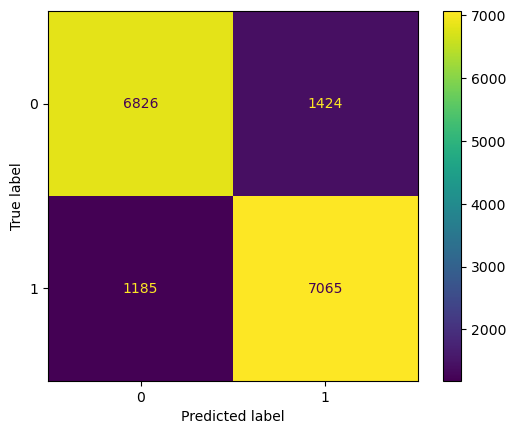

In [69]:
confusion_matrix = metrics.confusion_matrix(y_test, y_test_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [71]:
# ne mogu se izracunati za nelinarni kernel
# final_svm.model.coef_

### K najblizih suseda

In [39]:
X_train_vectorized.shape, X_val_vectorized.shape

((26800, 351), (6700, 351))

In [40]:
Ks = np.array([10*i for i in range(1, 10)])
dist_metrics = ['manhattan', 'euclidean']

best_score = float('-inf')
best_params = {'K': None, 'metric': None}

accuracies = {'manhattan': [], 'euclidean': []}                     
              
for K in Ks:
    for metric in dist_metrics:
        model = neighbors.KNeighborsClassifier(n_neighbors=K, metric=metric)
              
        model.fit(X_train_vectorized, y_train)
        score = metrics.accuracy_score(y_val, model.predict(X_val_vectorized))
        accuracies[metric].append(score)
        # print(f'K: {K} metric: {metric} - score: {score}')
        if score > best_score:
            best_score = score
            best_params['K'] = K
            best_params['metric'] = metric

# print('------------------------------------------------------------------------')            
print(f"Najbolji broj suseda : {best_params['K']}")
print(f"Najbolja metrika: {best_params['metric']}")
print(f'Najbolji skor: {best_score}')

Najbolji broj suseda : 50
Najbolja metrika: euclidean
Najbolji skor: 0.7756716417910448


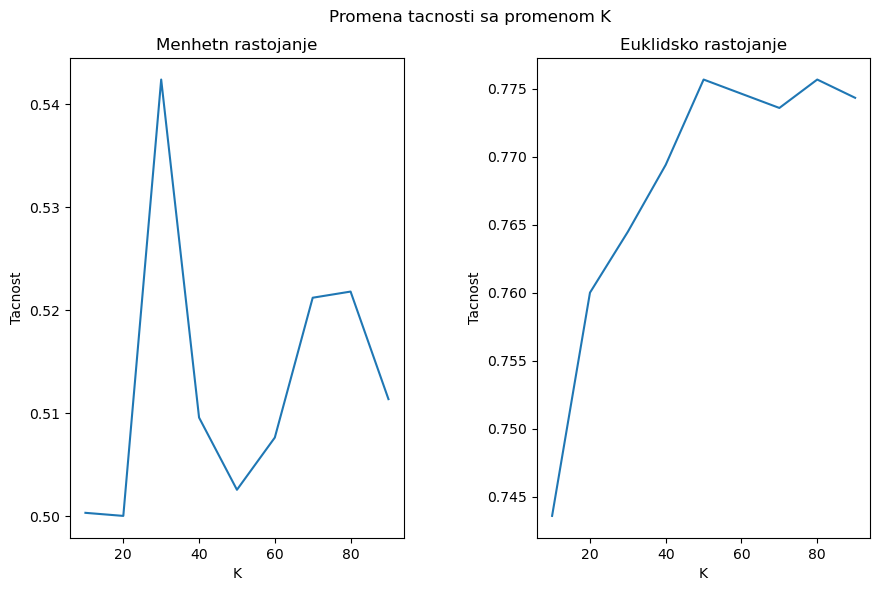

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.plot(Ks, accuracies['manhattan'])
ax1.set_title('Menhetn rastojanje')
ax1.set_xlabel('K')
ax1.set_ylabel('Tacnost')

ax2.plot(Ks, accuracies['euclidean'])
ax2.set_title('Euklidsko rastojanje')
ax2.set_xlabel('K')
ax2.set_ylabel('Tacnost')

fig.suptitle('Promena tacnosti sa promenom K')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.show()

In [42]:
final_knn_model = neighbors.KNeighborsClassifier(n_neighbors=best_params['K'], metric=best_params['metric'])

In [43]:
final_knn_model.fit(X_train_val_vec, y_train_val)

KNeighborsClassifier(metric='euclidean', n_neighbors=50)

In [44]:
knn_train_score = final_knn_model.score(X_train_val_vec, y_train_val)
print(knn_train_score)

0.7893432835820896


In [45]:
knn_test_score = final_knn_model.score(X_test_vec, y_test)
print(knn_test_score)

0.7821818181818182


In [46]:
y_test_predicted = final_knn_model.predict(X_test_vec)

In [47]:
print(metrics.classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77      8250
           1       0.77      0.81      0.79      8250

    accuracy                           0.78     16500
   macro avg       0.78      0.78      0.78     16500
weighted avg       0.78      0.78      0.78     16500



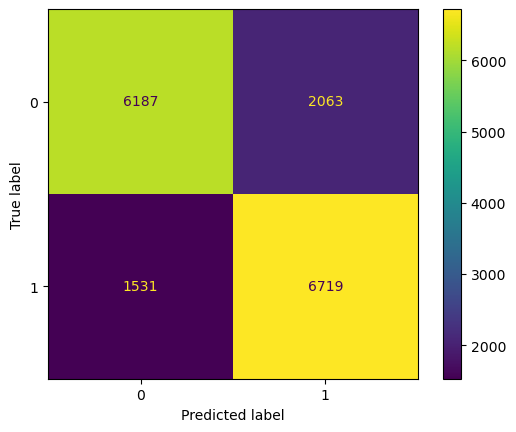

In [48]:
confusion_matrix = metrics.confusion_matrix(y_test, y_test_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()